In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
import tensorflow as tf
from tensorflow.keras import backend as K
import pandas as pd
from tensorflow.keras.layers import Input, GRU, Dense,Conv1D, Masking, Reshape, BatchNormalization, Flatten, Conv1DTranspose, RepeatVector, TimeDistributed, Bidirectional, MaxPooling1D,Activation, GaussianNoise, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
import tensorflow_probability as tfp

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Data

In [2]:
DATA = np.load('./Data/AsanTRSet.npy')

#### Env setting

In [33]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
### Model checkpoint
ModelSaveSameName = save_path+'PSVAE3_Mask.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=500)

LatDim = 2
SigDim = DATA.shape[1]
MaskingRate = 0.025
GaussStd1 = 0.002
GaussStd2 = 0.1

def ReName (layer, name):
    return Lambda(lambda x: x, name=name)(layer)

In [4]:
def MaskingGen ( InpRegul, MaskingRate = 0.025, GaussStd2 = 0.1):
    ## Masking vector generation 1 vs 0
    NBatch = tf.shape(InpRegul)[0]
    
    MaskIDX = tf.random.shuffle(tf.range(NBatch * InpRegul.shape[1] ))
    CutIDX = tf.cast(  tf.cast(tf.shape(MaskIDX)[0], dtype=tf.float32) * (1-MaskingRate), dtype=tf.int32 )
    MaskIDX = tf.cast(MaskIDX < CutIDX, dtype=tf.float32)
    MaskVec = tf.reshape(MaskIDX, (NBatch, -1))[:,:,None]
    
    ## Noise vector generation 1 vs 0
    RevMaskIDX = MaskIDX == 0
    RevMaskIDX = tf.cast(RevMaskIDX, dtype=tf.float32)
    NoisVec = RevMaskIDX * tf.random.normal(tf.shape(RevMaskIDX), stddev=GaussStd2)
    NoisVec = tf.reshape(NoisVec, (NBatch, -1))[:,:,None]
    return MaskVec, NoisVec

def GenLowFilter (LF, BL, N = 401):
    nVec = np.arange(N)
    KaiserBL = tf.signal.kaiser_window(N, beta=BL)

    # A low-pass filter
    X = 2 * LF * (nVec - (N - 1) / 2)
    X = tf.maximum(X , 1e-7)
    LPF = tf.sin(np.pi*X)/(np.pi*X)
    LPF *= KaiserBL
    LPF /= tf.reduce_sum(LPF, axis=-1, keepdims=True)
    
    return LPF[:,None] 


def GenHighFilter (HF, BH, N = 401):
    nVec = np.arange(N)
    KaiserBH = tf.signal.kaiser_window(N, beta=BH)

    # A high-pass filter
    Y = 2 * HF * (nVec - (N - 1) / 2)
    Y = tf.maximum(Y , 1e-7)
    HPF = tf.sin(np.pi*Y)/(np.pi*Y)
    HPF *= KaiserBH
    HPF /= tf.reduce_sum(HPF, axis=-1, keepdims=True)
    HPF = -HPF

    ## HPF[(N - 1) // 2] += 1
    Mask = np.zeros(HPF.shape[1])
    Mask[(N - 1) // 2] += 1
    Mask = tf.constant(Mask, dtype=tf.float32)
    HPF = HPF + Mask
    
    return HPF[:,None] 

### Encoder

In [36]:
training = True

InpL = Input(shape=(SigDim,))
InpFrame = tf.signal.frame(InpL, 100, 100)

if training:
    InpRegul = GaussianNoise(stddev=GaussStd1)(InpFrame, training=training)
    MaskVec, NoisVec = MaskingGen(InpRegul, MaskingRate, GaussStd2)
    EncInp = Masking(mask_value=0.)(InpRegul * MaskVec )
    EncOut = InpRegul + NoisVec
else:
    EncInp, EncOut = InpFrame, InpFrame

EncGRUOut = Bidirectional(GRU(50, return_sequences=True))(EncInp)
EncGRUOut = Bidirectional(GRU(20, return_sequences=False))(EncGRUOut)

Zs = Dense(20, activation='relu')(EncGRUOut)
Zs = Dense(10, activation='relu')(Zs)
Z_Mean = Dense(LatDim, activation='linear', name='Z_Mean')(Zs) 
Z_Log_Sigma = Dense(LatDim, activation='softplus', name='Z_Log_Sigma')(Zs)

# Reparameterization Trick for sampling 
Epsilon = K.random_normal(shape=(tf.shape(Z_Mean)[0], Z_Mean.shape[1]), mean=0., stddev=0.1)
#Epsilon = Lambda(lambda x: x, name="Epsilon")(Epsilon)
Epsilon = ReName(Epsilon,'Epsilon')

Z_Sampled = Z_Mean + tf.exp(0.5 * Z_Log_Sigma) * Epsilon
#Z_Sampled = Lambda(lambda x: x, name="Z_Sampled")(Z_Sampled)
Z_Sampled = ReName(Z_Sampled,'Z_Sampled')


EncModel = Model(InpL, [Flatten()(EncOut), Z_Mean, Z_Log_Sigma, Z_Sampled])
    


##### Debugging

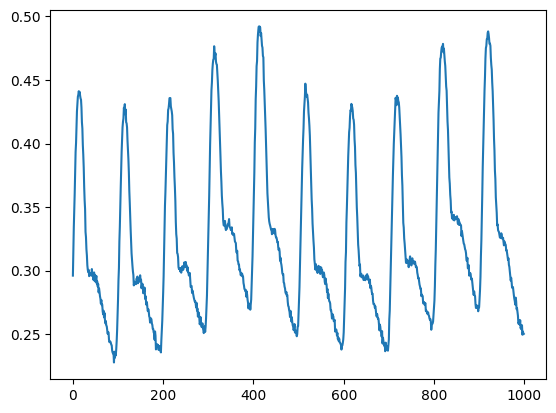

In [10]:
#EncModel.save_weights('./Results/tmp.hdf5')
#EncModel.load_weights('./Results/tmp.hdf5')
tmp = EncModel.predict(DATA[:100])[0]
#tmp = VAEM.predict(DATA[:100])
plt.plot(tmp[9])

### Decoder

In [41]:

InpZ = Input(shape=(LatDim,), name='InpZmean')
EncReInp = Input(shape=(SigDim,))

FiltPar = Dense(4, activation='relu')(InpZ)
FiltPar = Dense(8, activation='relu')(FiltPar)
FiltPar = Dense(4*3, activation='linear')(FiltPar) # Num. of parameters for filtering : 4, Num. of filtering : 3 

LHFs = Activation('sigmoid')(FiltPar[:, :(4*3)//2])
LHFs = Reshape((-1,2), name='LHFs')(LHFs)

LHBs = Activation('softplus')(FiltPar[:, (4*3)//2:])
LHBs = Reshape((-1,2), name='LHBs')(LHBs)



### Filtering level 1
## Filter generation
HPF_11 = GenHighFilter(LHFs[:, 0, 0:1], LHBs[:, 0, 0:1], N=301)
LPF_11 = GenLowFilter(LHFs[:, 0, 1:2],  LHBs[:, 0, 1:2],  N=201)

## Perform signal filtering level 1
InpFrame_11 =  tf.signal.frame(EncReInp, HPF_11.shape[-1], 1)
HpSig_11 = tf.reduce_sum(InpFrame_11*HPF_11[:,:,::-1], axis=-1, keepdims=True)
HpSig_11 = ReName(HpSig_11, 'HpSig_11')
InpFrame_11 =  tf.signal.frame(EncReInp, LPF_11.shape[-1], 1)
LpSig_11 = tf.reduce_sum(InpFrame_11*LPF_11[:,:,::-1], axis=-1, keepdims=True)
LpSig_11 = ReName(LpSig_11, 'LpSig_11')


### Filtering level 21 (from HpSig_11)
## Filter generation
HPF_21 = GenHighFilter(LHFs[:, 1, 0:1], LHBs[:, 1, 0:1], N=401)
LPF_21 = GenLowFilter(LHFs[:, 1, 1:2],  LHBs[:, 1, 1:2],  N=301)

## Perform signal filtering level 2
InpFrame_21 =  tf.signal.frame(HpSig_11[:,:,0], HPF_21.shape[-1], 1)
HpSig_21 = tf.reduce_sum(InpFrame_21*HPF_21[:,:,::-1], axis=-1, keepdims=True)
HpSig_21 = ReName(HpSig_21, 'HpSig_21')
InpFrame_21 =  tf.signal.frame(HpSig_11[:,:,0], LPF_21.shape[-1], 1)
LpSig_21 = tf.reduce_sum(InpFrame_21*LPF_21[:,:,::-1], axis=-1, keepdims=True)
LpSig_21 = ReName(LpSig_21, 'LpSig_21')

### Filtering level 22 (from LpSig_11)
## Filter generation
HPF_22 = GenHighFilter(LHFs[:, 2, 0:1], LHBs[:, 2, 0:1], N=301)
LPF_22 = GenLowFilter(LHFs[:, 2, 1:2],  LHBs[:, 2, 1:2],  N=201)

## Perform signal filtering level 2
InpFrame_22 =  tf.signal.frame(LpSig_11[:,:,0], HPF_22.shape[-1], 1)
HpSig_22 = tf.reduce_sum(InpFrame_22*HPF_22[:,:,::-1], axis=-1, keepdims=True)
HpSig_22 = ReName(HpSig_22, 'HpSig_22')
InpFrame_22 =  tf.signal.frame(LpSig_11[:,:,0], LPF_22.shape[-1], 1)
LpSig_22 = tf.reduce_sum(InpFrame_22*LPF_22[:,:,::-1], axis=-1, keepdims=True)
LpSig_22 = ReName(LpSig_22, 'LpSig_22')

## GRU NET
Dec_HpSig_11 = Reshape((-1, 100))(HpSig_11)
Dec_LpSig_11 = Reshape((-1, 100))(LpSig_11)
Dec_HpSig_21 = Reshape((-1, 100))(HpSig_21)
Dec_LpSig_21 = Reshape((-1, 100))(LpSig_21)
Dec_HpSig_22 = Reshape((-1, 100))(HpSig_22)
Dec_LpSig_22 = Reshape((-1, 100))(LpSig_22)

Dec_HpSig_11 = Bidirectional(GRU(5))(Dec_HpSig_11)
Dec_LpSig_11 = Bidirectional(GRU(5))(Dec_LpSig_11)
Dec_HpSig_21 = Bidirectional(GRU(5))(Dec_HpSig_21)
Dec_LpSig_21 = Bidirectional(GRU(5))(Dec_LpSig_21)
Dec_HpSig_22 = Bidirectional(GRU(5))(Dec_HpSig_22)
Dec_LpSig_22 = Bidirectional(GRU(5))(Dec_LpSig_22)

Decoder = tf.concat([Dec_HpSig_11, Dec_LpSig_11, Dec_HpSig_21, Dec_LpSig_21, Dec_HpSig_22, Dec_LpSig_22], axis=1)
Decoder = RepeatVector((SigDim//100) )(Decoder)
Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
Decoder = TimeDistributed(Dense(100))(Decoder)
#Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
DecOut = Dense(100, activation='sigmoid')(Decoder)
DecOut = Reshape((SigDim,),name='DecOut')(DecOut)


DecModel = Model([EncReInp, InpZ], DecOut)

In [49]:
DecModel.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InpZmean (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 4)            12          InpZmean[0][0]                   
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 8)            40          dense_29[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 12)           108         dense_30[0][0]                   
___________________________________________________________________________________________

### Vae Loss; RecMSE and KL Divergence¶

In [15]:
# apply beta and capacity
Capacity = 0.01
Beta = 1.0


### Vae Loss; KL Divergence
kl_Loss = 0.5 * tf.reduce_sum( Z_Mean**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
#kl_Loss = beta *tf.reduce_mean(kl_Loss )

kl_Loss = tf.reduce_mean(kl_Loss )
#kl_Loss = Beta * tf.abs(kl_Loss - Capacity)

def RECMSE (y_true, y_pred):
    
    RecMSE = tf.losses.mse(y_true, y_pred)
    RecMSE *= InpL.shape[1]
    
    return RecMSE

In [16]:
VAEOut = DecModel([EncModel(InpL)[0], EncModel(InpL)[3]])
VAEOut = Reshape((SigDim,), name='VAEOut')(VAEOut)
VAEM = Model(InpL, VAEOut, name='vae_mlp')

VAEM.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"VAEOut":'mse'})
#VAEM.compile(optimizer='adam', loss=RECMSE, metrics={"VAEOut":'mse'})
VAEM.add_loss(kl_Loss )
VAEM.add_metric(kl_Loss, 'KL_D')
VAEM.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
model_1 (Functional)            [(None, 1000), (None 61314       input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 1000)         73220       model_1[0][0]                    
                                                                 model_1[1][3]                    
____________________________________________________________________________________________

In [17]:
#VAEM.load_weights(ModelSaveSameName)
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

VAEM.fit(DATA[:], DATA[:], batch_size=1000, epochs=500, shuffle=True, validation_split=0.2, callbacks=[ModelSave, EarlyStop])

Epoch 1/500
102/320 [========>.....................] - ETA: 57s - loss: 0.0779 - mse: 0.0216 - KL_D: 0.0165


KeyboardInterrupt



In [144]:
#VAEM.save_weights('./Results/Masktmp')
#VAEM.load_weights('./Results/Masktmp')


#### Rec pred by zMean sample

In [11]:
VAEM.load_weights(ModelSaveSameName)
#Pred =VAEM.predict(DATA[:], batch_size=1000, verbose=1)
VAEM.evaluate(DATA[:], DATA[:], batch_size=2000, verbose=1)
#np.mean((DATA[:]- Pred)**2)

200/200 [==============================] - 11s 56ms/step - loss: 6.2545e-04 - mse: 6.2535e-04 - KL_D: 1.0242e-07


[0.0006254484178498387, 0.0006253462051972747, 1.0241907233421443e-07]

#### Rec pred by zMean 

In [12]:
VAEM.load_weights(ModelSaveSameName)
VAEOut = DecModel([EncModel(InpL)[0], EncModel(InpL)[1]])
VAEOut = Reshape((SigDim,), name='VAEOut')(VAEOut)

RecM = Model(InpL, VAEOut, name='vae_mlp')
Pred = RecM.predict(DATA[:], batch_size=2000, verbose=1 )
RecM.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics= {"VAEOut":'mse'}) #{"VAEOut":'mse'}
RecM.evaluate(DATA[:], DATA[:], batch_size=2000, verbose=1)
np.mean((DATA[:]- Pred)**2)

200/200 [==============================] - 16s 55ms/step - loss: 6.2412e-04 - mse: 6.2412e-04


0.00062535104

#### Components pred

In [13]:
VAEM.load_weights(ModelSaveSameName)
LatM = Model([InpL2,InpZ], [HpSig_11, LpSig_11, HpSig_21, LpSig_21, HpSig_22, LpSig_22 ])
ParaM = Model([InpL2,InpZ], [LHFs, LHBs ])


Pred_ZMean = Model(InpL, Z_Mean).predict(DATA[:10])
PredLat = LatM.predict([DATA[:10],Pred_ZMean] )
PredPara = ParaM.predict([DATA[:10],Pred_ZMean] )
#Pred =VAEM.predict(DATA[:10])


#### Variational pred

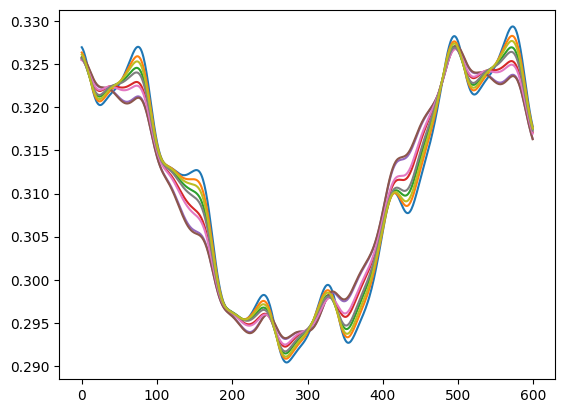

In [32]:
Pred_ZSampled = np.array([np.linspace(-30, 30, 10), np.linspace(-30, 30, 10)]).T
DataSample = np.tile(DATA[1:2].T, 10).T
PredLat = LatM.predict([DataSample,Pred_ZSampled] )

idx = 5
#plt.plot(DATA[idx])
for i in range(9):
    plt.plot(PredLat[idx][i, :1000, 0])
    #print(PredLat[i].shape)

In [13]:
PredLat[0].shape

(10, 700, 1)

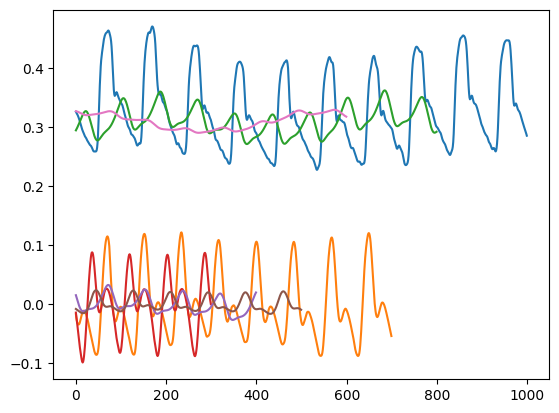

In [33]:
idx = 0
plt.plot(DATA[idx])
for i in range(6):
    plt.plot(PredLat[i][idx, :1000, 0])
    #print(PredLat[i].shape)


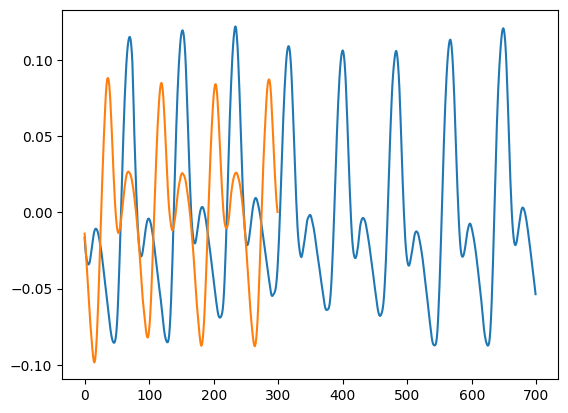

In [34]:
idx = 0
plt.plot(PredLat[0][idx, :1000, 0])
plt.plot(PredLat[2][idx, :1000, 0])


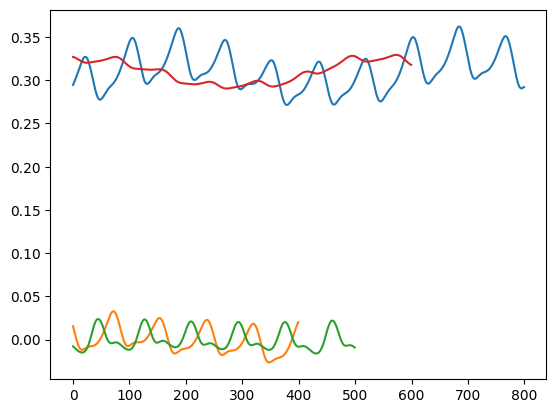

In [35]:
plt.plot(PredLat[1][idx, :, 0])
plt.plot(PredLat[3][idx, :, 0])
plt.plot(PredLat[4][idx, :, 0])
plt.plot(PredLat[5][idx, :, 0])

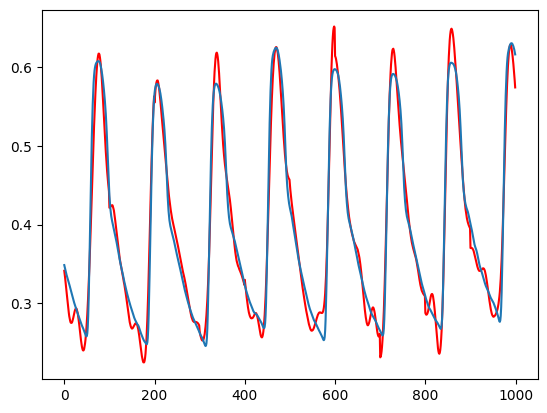

In [36]:
idx= 5
plt.plot(Pred[idx], c='red')
plt.plot(DATA[idx])



100